In [1]:
import os
from zen_garden.postprocess.results import Results

In [2]:
dataset_name_1 = 'Data_WT'
output_path_1 = os.path.join("outputs", dataset_name_1)
r1 = Results(output_path_1)

In [3]:
results = Results(output_path_1)
opex_var_unit = results.get_unit("opex_specific_variable")
opex_fixed_unit = results.get_unit("opex_specific_fixed")
opex_var_unit

technology
Bauxite_Aluminium              MEURO / GW
Carbon_Fiber_Blade             MEURO / GW
Copper_Ore_Copper              MEURO / GW
Iron_Ore_Steel                 MEURO / GW
Limestone_Concrete             MEURO / GW
Nacelle_Factory                MEURO / GW
Oil_Carbon_Fiber               MEURO / GW
Permanent_Magnets_Factory      MEURO / GW
REE_Ore_REE                    MEURO / GW
Tower_Factory                  MEURO / GW
Turbine_Installation           MEURO / GW
Aluminium_transport            MEURO / GW
Bauxite_transport              MEURO / GW
Blade_transport                MEURO / GW
Carbon_Fiber_transport         MEURO / GW
Concrete_transport             MEURO / GW
Copper_Ore_transport           MEURO / GW
Copper_transport               MEURO / GW
Iron_Ore_transport             MEURO / GW
Limestone_transport            MEURO / GW
Nacelle_transport              MEURO / GW
Oil_transport                  MEURO / GW
Permanent_Magnets_transport    MEURO / GW
REE_Ore_transport      

In [4]:
opex_fixed_unit

technology          capacity_type
Bauxite_Aluminium   power                MEURO / GW
Carbon_Fiber_Blade  power                MEURO / GW
Copper_Ore_Copper   power                MEURO / GW
Iron_Ore_Steel      power                MEURO / GW
Limestone_Concrete  power                MEURO / GW
                                          ...      
Steel_storage       power                MEURO / GW
Tower_storage       energy           MEURO / GW / h
                    power                MEURO / GW
Turbine_storage     energy           MEURO / GW / h
                    power                MEURO / GW
Name: units, Length: 62, dtype: object

In [5]:
dataset_name_2 = 'Data_WT_new'
output_path_2 = os.path.join("outputs", dataset_name_2)
r2 = Results(output_path_2)

In [6]:
# get capacity
demand = r1.get_total('demand')
demand

0      1      2      3       4       5  \
           carrier   node                                                
scenario_  Aluminium AUS    0.000  0.000  0.000  0.000   0.000   0.000   
                     BRA    0.000  0.000  0.000  0.000   0.000   0.000   
                     CHE    0.000  0.000  0.000  0.000   0.000   0.000   
                     CHN    0.000  0.000  0.000  0.000   0.000   0.000   
                     DEU    0.000  0.000  0.000  0.000   0.000   0.000   
...                           ...    ...    ...    ...     ...     ...   
scenario_2 Turbine   NLD    0.691  0.776  0.794  0.212   0.117   0.112   
                     ROE    9.319  9.386  9.986  8.576   8.488   9.120   
                     ROW    3.898  8.119  3.639  5.214   7.362   9.849   
                     SWE    1.398  2.003  3.069  0.616   1.793   0.900   
                     USA   13.037  8.927  7.034  8.359  10.946  14.946   

                                6       7       8       9  
           carrier   node                                  
scenario_  Aluminium AUS    0.000   0.000   0.000   0.000  
                     BRA    0.000   0.000   0.000   0.000  
                     CHE    0.000   0.000   0.000   0.000  
                     CHN    0.000   0.000   0.000   0.000  
                     DEU    0.000   0.000   0.000   0.000  
...                           ...     ...     ...     ...  
scenario_2 Turbine   NLD    0.130   0.130   0.130   0.130  
                     ROE    9.777  10.439  12.146  13.303  
                     ROW   12.609  12.589  11.296  12.300  
                     SWE    0.616   0.635   0.433   0.380  
                     USA   15.904  17.087  18.122  19.769  

[714 rows x 10 columns]

In [7]:
# get capacity
demand = r2.get_total('demand')
demand

0       1      2      3        4        5  \
           carrier   node                                                    
scenario_  Aluminium AUS    0.0000  0.0000  0.000  0.000   0.0000   0.0000   
                     BRA    0.0000  0.0000  0.000  0.000   0.0000   0.0000   
                     CHE    0.0000  0.0000  0.000  0.000   0.0000   0.0000   
                     CHN    0.0000  0.0000  0.000  0.000   0.0000   0.0000   
                     DEU    0.0000  0.0000  0.000  0.000   0.0000   0.0000   
...                            ...     ...    ...    ...      ...      ...   
scenario_2 Turbine   NLD    0.6910  0.7760  0.794  0.212   0.1170   0.1120   
                     ROE   86.9554  0.0068  0.000  0.002   0.0226   0.0076   
                     ROW    3.8980  8.1190  3.639  5.214   7.3620   9.8490   
                     SWE    1.3980  2.0030  3.069  0.616   1.7930   0.9000   
                     USA   13.0370  8.9270  7.034  8.359  10.9460  14.9460   

                                 6       7       8        9  
           carrier   node                                    
scenario_  Aluminium AUS    0.0000   0.000   0.000   0.0000  
                     BRA    0.0000   0.000   0.000   0.0000  
                     CHE    0.0000   0.000   0.000   0.0000  
                     CHN    0.0000   0.000   0.000   0.0000  
                     DEU    0.0000   0.000   0.000   0.0000  
...                            ...     ...     ...      ...  
scenario_2 Turbine   NLD    0.1300   0.130   0.130   0.1300  
                     ROE    7.7293   5.978  19.218  48.0183  
                     ROW   12.6090  12.589  11.296  12.3000  
                     SWE    0.6160   0.635   0.433   0.3800  
                     USA   15.9040  17.087  18.122  19.7690  

[714 rows x 10 columns]

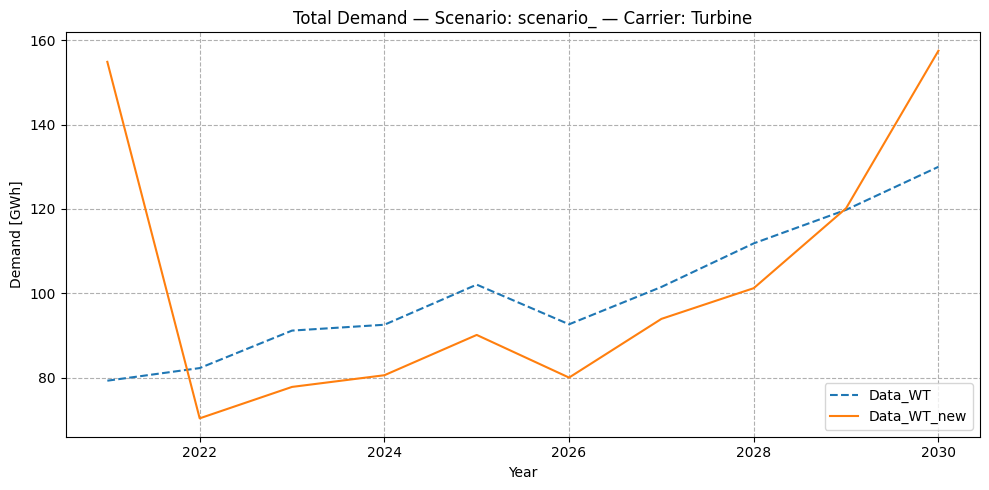

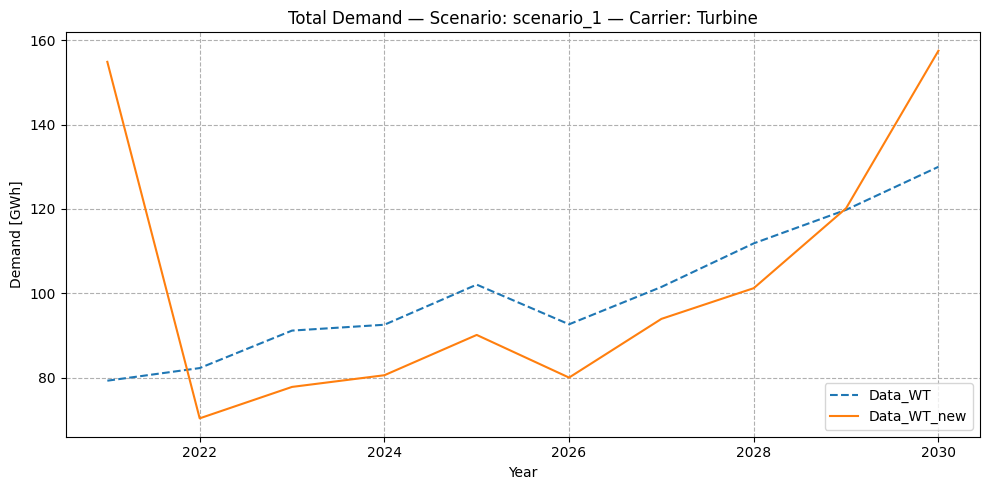

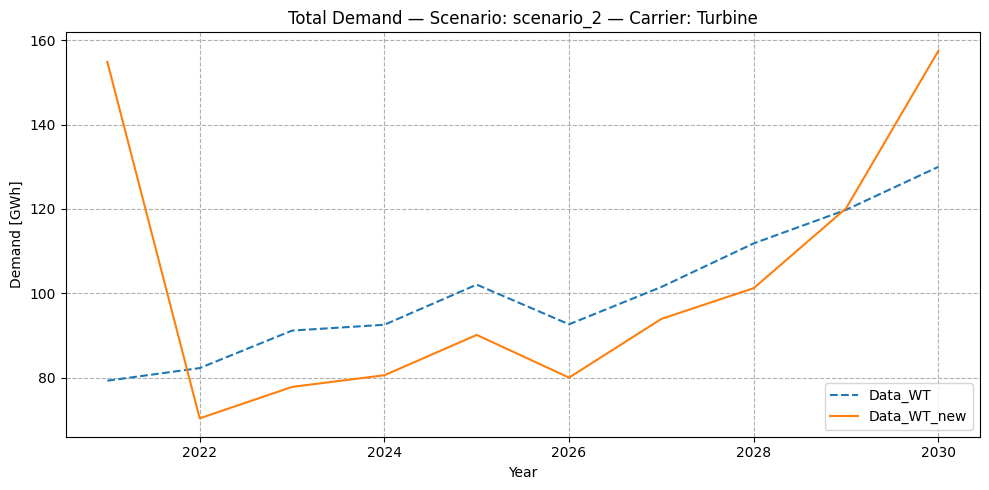

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset and clean up
demand1 = r1.get_full_ts("demand").reset_index()
demand2 = r2.get_full_ts("demand").reset_index()

# Rename scenario column for clarity
demand1 = demand1.rename(columns={"level_0": "scenario"})
demand2 = demand2.rename(columns={"level_0": "scenario"})

# Define year columns (int only)
year_cols = [col for col in demand1.columns if isinstance(col, int)]
years = [2021 + int(col) for col in year_cols]  # Adjust if needed

# Loop over scenarios
scenarios = demand1["scenario"].unique()

for scenario in scenarios:
    d1_s = demand1[demand1["scenario"] == scenario]
    d2_s = demand2[demand2["scenario"] == scenario]

    # Group by carrier (e.g. power, heat, etc.)
    d1_grouped = d1_s.groupby("carrier")[year_cols].sum()
    d2_grouped = d2_s.groupby("carrier")[year_cols].sum()

    # Filter to only carriers with non-zero demand
    carriers = sorted(set(d1_grouped.index).union(d2_grouped.index))
    non_zero = [
        carrier for carrier in carriers
        if d1_grouped.loc[carrier].sum() > 0 or d2_grouped.loc[carrier].sum() > 0
    ]

    # Plot per carrier
    for carrier in non_zero:
        plt.figure(figsize=(10, 5))
        plt.plot(years, d1_grouped.loc[carrier], label=f"{dataset_name_1}", linestyle="--")
        plt.plot(years, d2_grouped.loc[carrier], label=f"{dataset_name_2}", linestyle="-")
        plt.title(f"Total Demand — Scenario: {scenario} — Carrier: {carrier}")
        plt.xlabel("Year")
        plt.ylabel("Demand [GWh]")
        plt.grid(True, linestyle="--")
        plt.legend()
        plt.tight_layout()
        plt.show()